In [15]:
!apt-get install -y gmsh
!pip install gmsh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gmsh is already the newest version (4.8.4+ds2-2build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [16]:
import gmsh
gmsh.initialize()
gmsh.finalize()
print("Gmsh installed!")

Gmsh installed!


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.spatial import KDTree
import time

In [18]:
try:
    import gmsh
    GMSH_AVAILABLE = True
except ImportError:
    GMSH_AVAILABLE = False
    print("Warning: GMSH python API not found.")

**ПРИКЛАД 1**

In [19]:
def generate_mesh(domain_type='square', mesh_size=0.05, polygon_pts=None):
    if GMSH_AVAILABLE:
        gmsh.initialize()
        gmsh.model.add("domain")
        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", mesh_size)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", mesh_size)

        if domain_type == 'polygon':
            if polygon_pts is None: raise ValueError("Provide polygon_pts")
            pts = []
            for (x,y) in polygon_pts:
                pts.append(gmsh.model.geo.addPoint(x,y,0.0, mesh_size))
            lines = []
            for i in range(len(pts)):
                lines.append(gmsh.model.geo.addLine(pts[i], pts[(i+1)%len(pts)]))
            loop = gmsh.model.geo.addCurveLoop(lines)
            surface = gmsh.model.geo.addPlaneSurface([loop])

        gmsh.model.geo.synchronize()
        gmsh.model.mesh.generate(2)

        node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
        node_coords = np.array(node_coords).reshape(-1,3)[:,:2]
        tag_to_idx = {int(tag): i for i, tag in enumerate(node_tags)}
        base_nodes = node_coords.copy()

        elem_types, elem_tags, elem_node_tags = gmsh.model.mesh.getElements(dim=2)
        tri_block = None
        for et, tags, nodes_list in zip(elem_types, elem_tags, elem_node_tags):
            if et == 2: tri_block = nodes_list; break
        if tri_block is None:
             for et, tags, nodes_list in zip(elem_types, elem_tags, elem_node_tags):
                if len(nodes_list) > 0 and (len(nodes_list) // len(tags) == 3):
                    tri_block = nodes_list; break

        tri_nodes = np.array(tri_block, dtype=int)
        base_elems = tri_nodes.reshape(-1, 3)
        base_elems_idx = np.vectorize(tag_to_idx.get)(base_elems)

        gmsh.finalize()
        return base_nodes, base_elems_idx
    else:
        return None, None

def create_p2_tilde_mesh(base_nodes, base_elems):
    edge_to_mid = {}
    all_nodes = list(base_nodes.copy())
    p2_elems = np.zeros((len(base_elems), 7), dtype=int)
    centers = []
    for i, tri in enumerate(base_elems):
        v0, v1, v2 = int(tri[0]), int(tri[1]), int(tri[2])
        p2_elems[i, 0:3] = [v0, v1, v2]
        edges = [(v0, v1), (v1, v2), (v2, v0)]
        for j, e in enumerate(edges):
            key = tuple(sorted(e))
            if key not in edge_to_mid:
                mid_coord = 0.5 * (base_nodes[key[0]] + base_nodes[key[1]])
                edge_to_mid[key] = len(all_nodes)
                all_nodes.append(mid_coord)
            p2_elems[i, 3 + j] = edge_to_mid[key]
        center = np.mean(base_nodes[[v0, v1, v2]], axis=0)
        centers.append(center)
        p2_elems[i, 6] = len(all_nodes)
        all_nodes.append(center)
    return np.array(all_nodes), p2_elems, edge_to_mid, np.array(centers)

def get_P2_tilde_shape_functions():
    N = [lambda l: l[0]*(2*l[0]-1)+3*l[0]*l[1]*l[2], lambda l: l[1]*(2*l[1]-1)+3*l[0]*l[1]*l[2],
         lambda l: l[2]*(2*l[2]-1)+3*l[0]*l[1]*l[2], lambda l: 4*l[0]*l[1]-12*l[0]*l[1]*l[2],
         lambda l: 4*l[1]*l[2]-12*l[0]*l[1]*l[2], lambda l: 4*l[2]*l[0]-12*l[0]*l[1]*l[2],
         lambda l: 27*l[0]*l[1]*l[2]]
    grad_N = [
        lambda l: np.array([4*l[0]-1+3*l[1]*l[2], 3*l[0]*l[2], 3*l[0]*l[1]]),
        lambda l: np.array([3*l[1]*l[2], 4*l[1]-1+3*l[0]*l[2], 3*l[0]*l[1]]),
        lambda l: np.array([3*l[1]*l[2], 3*l[0]*l[2], 4*l[2]-1+3*l[0]*l[1]]),
        lambda l: np.array([4*l[1]-12*l[1]*l[2], 4*l[0]-12*l[0]*l[2], -12*l[0]*l[1]]),
        lambda l: np.array([-12*l[1]*l[2], 4*l[2]-12*l[0]*l[2], 4*l[1]-12*l[0]*l[1]]),
        lambda l: np.array([4*l[2]-12*l[1]*l[2], -12*l[0]*l[2], 4*l[0]-12*l[0]*l[1]]),
        lambda l: np.array([27*l[1]*l[2], 27*l[0]*l[2], 27*l[0]*l[1]])
    ]
    return N, grad_N

def gauss_quadrature_triangle_p4():
    w1, w2 = 0.223381589678011, 0.109951743655322
    a1, a2 = 0.445948490915965, 0.091576213509771
    pts = np.array([[a1, a1], [a1, 1-2*a1], [1-2*a1, a1], [a2, a2], [a2, 1-2*a2], [1-2*a2, a2]])
    wts = np.array([w1, w1, w1, w2, w2, w2])
    return pts, wts

def mass_lumping_weights():
    return np.array([1/20, 1/20, 1/20, 2/15, 2/15, 2/15, 9/20])

def assemble_system(nodes, elems, c_field):
    n_nodes = len(nodes)
    n_elems = len(elems)
    M_diag = np.zeros(n_nodes)
    weights = mass_lumping_weights()
    rows_A, cols_A, data_A = [], [], []
    _, grad_N_funcs = get_P2_tilde_shape_functions()
    quad_pts, quad_wts = gauss_quadrature_triangle_p4()

    for k in range(n_elems):
        el_nodes_idx = elems[k]
        verts = nodes[el_nodes_idx[0:3]]
        area = 0.5 * np.abs((verts[1,0]-verts[0,0])*(verts[2,1]-verts[0,1]) - (verts[1,1]-verts[0,1])*(verts[2,0]-verts[0,0]))

        for i in range(7):
            M_diag[el_nodes_idx[i]] += area * weights[i]

        b = np.array([verts[1,1]-verts[2,1], verts[2,1]-verts[0,1], verts[0,1]-verts[1,1]]) / (2*area)
        c = np.array([verts[2,0]-verts[1,0], verts[0,0]-verts[2,0], verts[1,0]-verts[0,0]]) / (2*area)
        c_sq = c_field[k]**2
        local_K = np.zeros((7, 7))

        for q in range(len(quad_wts)):
            l1, l2 = quad_pts[q]
            lam = np.array([1 - l1 - l2, l1, l2])
            dNi_dlam = [gn(lam) for gn in grad_N_funcs]
            dNi_dx = [np.dot(gn, b) for gn in dNi_dlam]
            dNi_dy = [np.dot(gn, c) for gn in dNi_dlam]
            factor = quad_wts[q] * area * c_sq
            for i in range(7):
                for j in range(7):
                    local_K[i, j] += (dNi_dx[i]*dNi_dx[j] + dNi_dy[i]*dNi_dy[j]) * factor

        for i in range(7):
            for j in range(7):
                cols_A.append(el_nodes_idx[j])
                rows_A.append(el_nodes_idx[i])
                data_A.append(local_K[i, j])

    A_mat = coo_matrix((data_A, (rows_A, cols_A)), shape=(n_nodes, n_nodes)).tocsr()
    return M_diag, A_mat

def calculate_stable_dt(nodes, elems, c_max, cfl_factor=0.1):
    tri_verts_idx = elems[:, 0:3]
    v0 = nodes[tri_verts_idx[:, 1]] - nodes[tri_verts_idx[:, 0]]
    v1 = nodes[tri_verts_idx[:, 2]] - nodes[tri_verts_idx[:, 1]]
    v2 = nodes[tri_verts_idx[:, 0]] - nodes[tri_verts_idx[:, 2]]
    L0 = np.linalg.norm(v0, axis=1)
    L1 = np.linalg.norm(v1, axis=1)
    L2 = np.linalg.norm(v2, axis=1)
    h_min_global = np.min([np.min(L0), np.min(L1), np.min(L2)])
    dt_safe = cfl_factor * (h_min_global / 2.0) / c_max
    print(f" Mesh h_min: {h_min_global:.2f} m, dt: {dt_safe:.6f} s")
    return dt_safe

In [20]:
L_x, L_y = 10000.0, 20000.0
c_out = 1000.0
c_in_fault = 600.0
source_pos = (L_x / 2, 2000.0)

scenarios = ['homogeneous', 1000.0, 500.0, 250.0]
styles = {
    'homogeneous': {'color': 'black', 'label': 'homogeneous', 'lw': 2.0},
    1000.0: {'color': 'red',   'label': 'h = 1.0 km',  'lw': 1.5},
    500.0:  {'color': 'blue',  'label': 'h = 0.5 km',  'lw': 1.5},
    250.0:  {'color': 'green', 'label': 'h = 0.25 km', 'lw': 1.5}
}

results = {}

poly_pts = [(0.0, 0.0), (L_x, 0.0), (L_x, L_y), (0.0, L_y)]
base_nodes, base_elems = generate_mesh('polygon', mesh_size=200.0, polygon_pts=poly_pts)
all_nodes, p2_elems, _, _ = create_p2_tilde_mesh(base_nodes, base_elems)
n_nodes = len(all_nodes)

dt = calculate_stable_dt(all_nodes, p2_elems, c_max=c_out, cfl_factor=0.1)
T_max = 30.0
n_steps = int(T_max / dt)
t_arr = np.linspace(0, T_max, n_steps)

s_width = 2000.0
decay_rate = 20.0
sigma = np.zeros(n_nodes)
for i, (x, y) in enumerate(all_nodes):
    dist = min(x, L_x - x, y, L_y - y)
    if dist < s_width:
        ratio = (s_width - dist) / s_width
        sigma[i] = decay_rate * (ratio ** 2)

tree = KDTree(all_nodes)
_, idx_S = tree.query(source_pos)

def source_func(t, t0=1.5, tau=0.25):
    if t < 0 or t > t0 + 10*tau: return 0.0
    if t > t0:
        return (t - t0) / (tau**2) * np.exp(-(t - t0)/tau)
    return 0.0

source_vals = [source_func(t) * 1e7 for t in t_arr]

for sc in scenarios:
    print(f"Simulating: {sc} ...")

    elem_centers = np.mean(all_nodes[p2_elems[:, 0:3]], axis=1)
    c_field = np.ones(len(p2_elems)) * c_out

    if sc == 'homogeneous':
        fw_val = 0.0
        rec_LSr_pos = (L_x / 2 + 500.0, 12000.0)
    else:
        fw_val = sc
        rec_LSr_pos = (L_x / 2 + fw_val/2 + 500.0, 12000.0)
        fault_mask = (elem_centers[:, 0] >= L_x/2 - fw_val/2) & \
                     (elem_centers[:, 0] <= L_x/2 + fw_val/2)
        c_field[fault_mask] = c_in_fault

    rec_LSc_pos = (L_x / 2, 12000.0)
    _, idx_LSc = tree.query(rec_LSc_pos)
    _, idx_LSr = tree.query(rec_LSr_pos)

    M_lumped, K_mat = assemble_system(all_nodes, p2_elems, c_field)
    inv_M = 1.0 / M_lumped

    u_prev, u_curr = np.zeros(n_nodes), np.zeros(n_nodes)
    hist_LSc_curr, hist_LSr_curr = [], []

    factor_com = (dt * sigma) / 2.0
    denom = 1.0 + factor_com
    c1 = 2.0
    c2 = 1.0 - factor_com

    start_t = time.time()
    for n in range(n_steps):
        t = t_arr[n]
        F_vec = np.zeros(n_nodes)
        F_vec[idx_S] = source_vals[n]

        Ku = K_mat.dot(u_curr)
        Accel = (F_vec - Ku) * inv_M

        u_next = (c1 * u_curr - c2 * u_prev + (dt**2) * Accel) / denom

        hist_LSc_curr.append(u_next[idx_LSc])
        hist_LSr_curr.append(u_next[idx_LSr])

        u_prev[:] = u_curr[:]
        u_curr[:] = u_next[:]

    print(f"  Done in {time.time() - start_t:.2f} s")
    results[sc] = {'LSc': hist_LSc_curr, 'LSr': hist_LSr_curr}

 Mesh h_min: 145.71 m, dt: 0.007285 s
Simulating: homogeneous ...
  Done in 4.26 s
Simulating: 1000.0 ...
  Done in 4.69 s
Simulating: 500.0 ...
  Done in 4.22 s
Simulating: 250.0 ...
  Done in 3.96 s


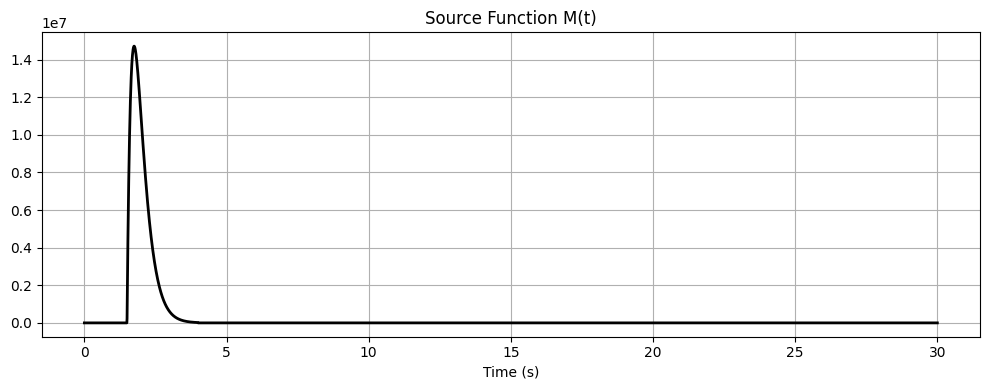

In [21]:
# Функція джерела
plt.figure(figsize=(10, 4))
plt.plot(t_arr, source_vals, 'k', linewidth=2)
plt.title("Source Function M(t)")
plt.xlabel("Time (s)")
plt.grid(True)
plt.tight_layout()
plt.show()

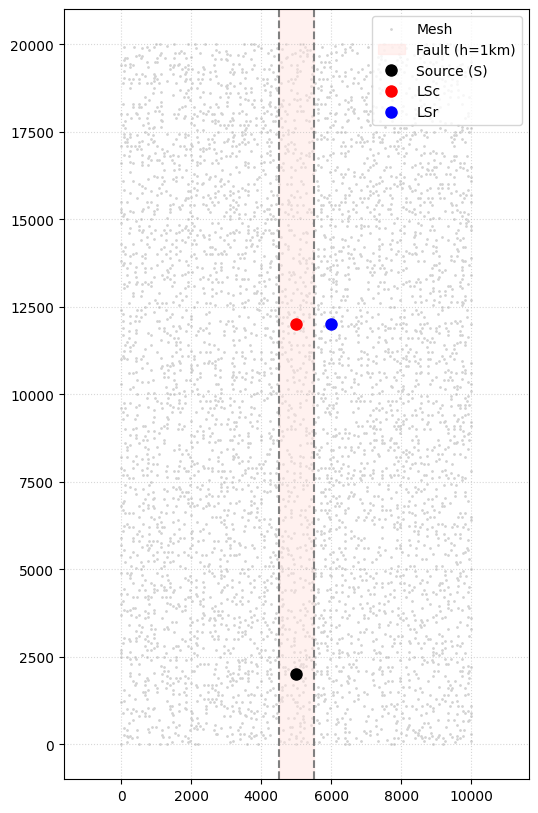

In [22]:
# Візуалізація області
plt.figure(figsize=(6, 10))

step = max(1, n_nodes // 5000)
plt.scatter(all_nodes[::step, 0], all_nodes[::step, 1], color='lightgray', s=1, label='Mesh')

fw_vis = 1000.0
plt.axvspan(L_x/2 - fw_vis/2, L_x/2 + fw_vis/2, color='mistyrose', alpha=0.5, label='Fault (h=1km)')
plt.axvline(L_x/2 - fw_vis/2, color='gray', linestyle='--')
plt.axvline(L_x/2 + fw_vis/2, color='gray', linestyle='--')

plt.plot(source_pos[0], source_pos[1], 'ko', markersize=8, label='Source (S)')
plt.plot(rec_LSc_pos[0], rec_LSc_pos[1], 'ro', markersize=8, label='LSc')
rec_LSr_vis = (L_x / 2 + fw_vis/2 + 500.0, 12000.0)
plt.plot(rec_LSr_vis[0], rec_LSr_vis[1], 'bo', markersize=8, label='LSr')
plt.axis('equal')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

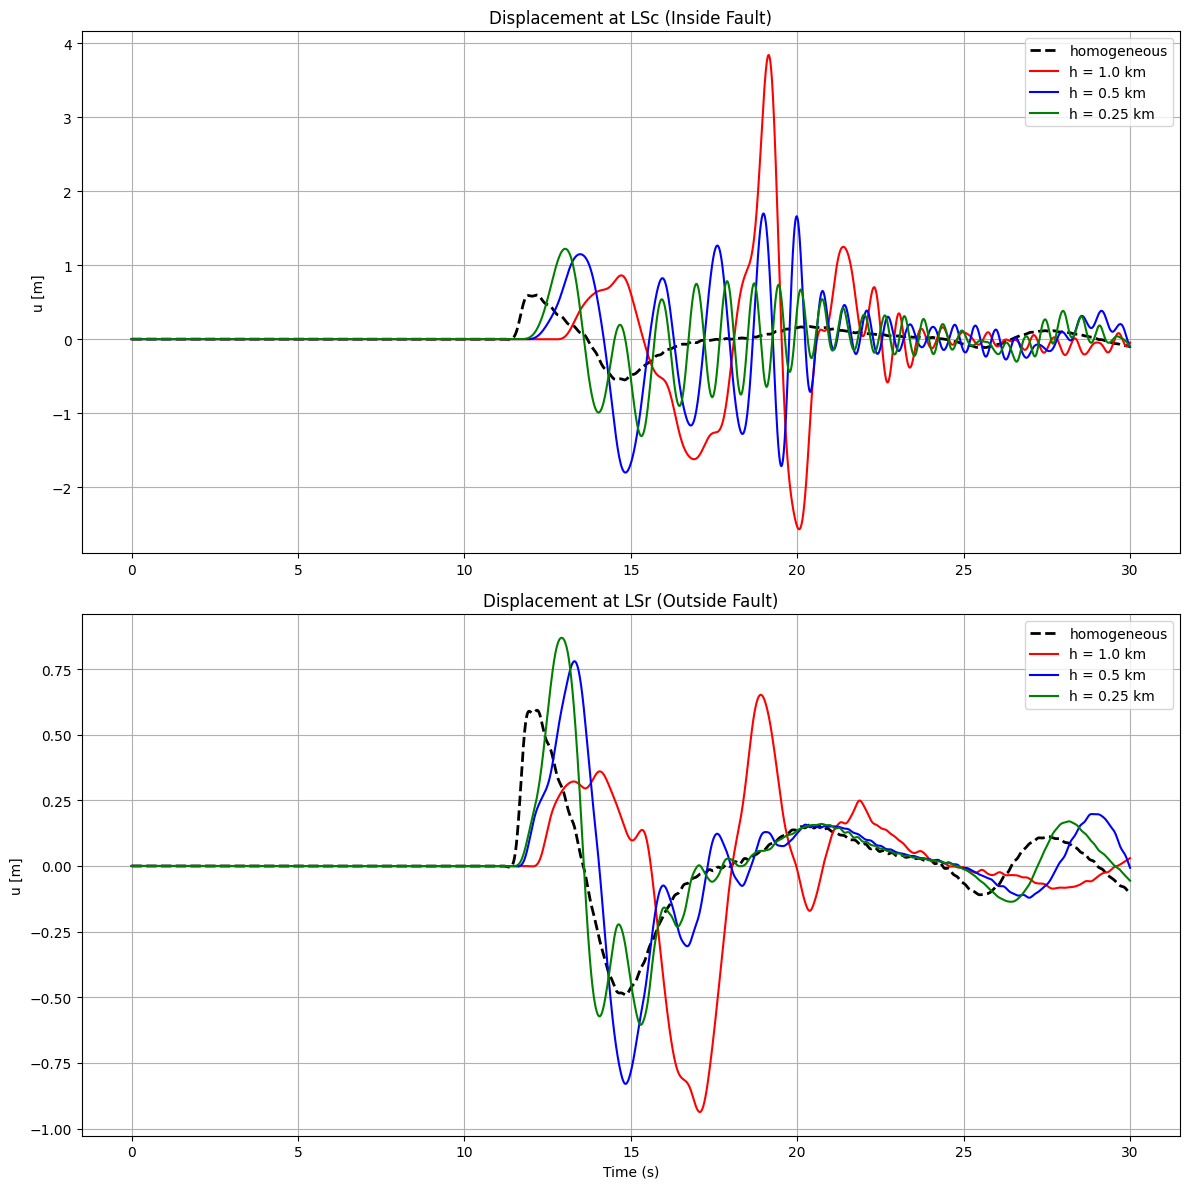

In [23]:
# Порівняння переміщення
plt.figure(figsize=(12, 12))

# LSc
plt.subplot(2, 1, 1)
if 'homogeneous' in results:
    s = styles['homogeneous']
    plt.plot(t_arr, results['homogeneous']['LSc'], color=s['color'], label=s['label'], lw=s['lw'], ls='--')
for sc in scenarios:
    if sc == 'homogeneous': continue
    s = styles[sc]
    plt.plot(t_arr, results[sc]['LSc'], color=s['color'], label=s['label'], lw=s['lw'])
plt.title("Displacement at LSc (Inside Fault)")
plt.ylabel("u [m]")
plt.grid(True)
plt.legend(loc='upper right')

# LSr
plt.subplot(2, 1, 2)
if 'homogeneous' in results:
    s = styles['homogeneous']
    plt.plot(t_arr, results['homogeneous']['LSr'], color=s['color'], label=s['label'], lw=s['lw'], ls='--')
for sc in scenarios:
    if sc == 'homogeneous': continue
    s = styles[sc]
    plt.plot(t_arr, results[sc]['LSr'], color=s['color'], label=s['label'], lw=s['lw'])
plt.title("Displacement at LSr (Outside Fault)")
plt.xlabel("Time (s)")
plt.ylabel("u [m]")
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

**ПРИКЛАД 2**

In [24]:
def generate_mesh(domain_size=10000, mesh_size=100):
    if GMSH_AVAILABLE:
        gmsh.initialize()
        gmsh.model.add("domain")
        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", mesh_size)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", mesh_size)

        # Квадратна область 10x10 км
        p1 = gmsh.model.geo.addPoint(0.0, 0.0, 0.0, mesh_size)
        p2 = gmsh.model.geo.addPoint(domain_size, 0.0, 0.0, mesh_size)
        p3 = gmsh.model.geo.addPoint(domain_size, domain_size, 0.0, mesh_size)
        p4 = gmsh.model.geo.addPoint(0.0, domain_size, 0.0, mesh_size)
        l1 = gmsh.model.geo.addLine(p1, p2)
        l2 = gmsh.model.geo.addLine(p2, p3)
        l3 = gmsh.model.geo.addLine(p3, p4)
        l4 = gmsh.model.geo.addLine(p4, p1)
        loop = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4])
        surface = gmsh.model.geo.addPlaneSurface([loop])

        gmsh.model.geo.synchronize()
        gmsh.model.mesh.generate(2)

        node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
        node_coords = np.array(node_coords).reshape(-1,3)[:,:2]

        tag_to_idx = {int(tag): i for i, tag in enumerate(node_tags)}
        base_nodes = node_coords.copy()

        elem_types, elem_tags, elem_node_tags = gmsh.model.mesh.getElements(dim=2)
        tri_block = None
        for et, tags, nodes_list in zip(elem_types, elem_tags, elem_node_tags):
            if et == 2: tri_block = nodes_list; break

        if tri_block is None:
             for et, tags, nodes_list in zip(elem_types, elem_tags, elem_node_tags):
                if len(nodes_list) > 0 and (len(nodes_list) // len(tags) == 3):
                    tri_block = nodes_list; break

        tri_nodes = np.array(tri_block, dtype=int)
        base_elems = tri_nodes.reshape(-1, 3)
        base_elems_idx = np.vectorize(tag_to_idx.get)(base_elems)

        gmsh.finalize()
        return base_nodes, base_elems_idx
    else:
        return None, None

def create_p2_tilde_mesh(base_nodes, base_elems):
    edge_to_mid = {}
    all_nodes = list(base_nodes.copy())
    p2_elems = np.zeros((len(base_elems), 7), dtype=int)
    centers = []
    for i, tri in enumerate(base_elems):
        v0, v1, v2 = int(tri[0]), int(tri[1]), int(tri[2])
        p2_elems[i, 0:3] = [v0, v1, v2]
        edges = [(v0, v1), (v1, v2), (v2, v0)]
        for j, e in enumerate(edges):
            key = tuple(sorted(e))
            if key not in edge_to_mid:
                mid_coord = 0.5 * (base_nodes[key[0]] + base_nodes[key[1]])
                edge_to_mid[key] = len(all_nodes)
                all_nodes.append(mid_coord)
            p2_elems[i, 3 + j] = edge_to_mid[key]
        center = np.mean(base_nodes[[v0, v1, v2]], axis=0)
        centers.append(center)
        p2_elems[i, 6] = len(all_nodes)
        all_nodes.append(center)
    return np.array(all_nodes), p2_elems, edge_to_mid, np.array(centers)

def get_P2_tilde_shape_functions():
    N = [lambda l: l[0]*(2*l[0]-1)+3*l[0]*l[1]*l[2], lambda l: l[1]*(2*l[1]-1)+3*l[0]*l[1]*l[2],
         lambda l: l[2]*(2*l[2]-1)+3*l[0]*l[1]*l[2], lambda l: 4*l[0]*l[1]-12*l[0]*l[1]*l[2],
         lambda l: 4*l[1]*l[2]-12*l[0]*l[1]*l[2], lambda l: 4*l[2]*l[0]-12*l[0]*l[1]*l[2],
         lambda l: 27*l[0]*l[1]*l[2]]
    grad_N = [
        lambda l: np.array([4*l[0]-1+3*l[1]*l[2], 3*l[0]*l[2], 3*l[0]*l[1]]),
        lambda l: np.array([3*l[1]*l[2], 4*l[1]-1+3*l[0]*l[2], 3*l[0]*l[1]]),
        lambda l: np.array([3*l[1]*l[2], 3*l[0]*l[2], 4*l[2]-1+3*l[0]*l[1]]),
        lambda l: np.array([4*l[1]-12*l[1]*l[2], 4*l[0]-12*l[0]*l[2], -12*l[0]*l[1]]),
        lambda l: np.array([-12*l[1]*l[2], 4*l[2]-12*l[0]*l[2], 4*l[1]-12*l[0]*l[1]]),
        lambda l: np.array([4*l[2]-12*l[1]*l[2], -12*l[0]*l[2], 4*l[0]-12*l[0]*l[1]]),
        lambda l: np.array([27*l[1]*l[2], 27*l[0]*l[2], 27*l[0]*l[1]])
    ]
    return N, grad_N

def gauss_quadrature_triangle_p4():
    w1, w2 = 0.223381589678011, 0.109951743655322
    a1, a2 = 0.445948490915965, 0.091576213509771
    pts = np.array([[a1, a1], [a1, 1-2*a1], [1-2*a1, a1], [a2, a2], [a2, 1-2*a2], [1-2*a2, a2]])
    wts = np.array([w1, w1, w1, w2, w2, w2])
    return pts, wts

def mass_lumping_weights():
    return np.array([1/20, 1/20, 1/20, 2/15, 2/15, 2/15, 9/20])

def assemble_system(nodes, elems, c_field):
    n_nodes = len(nodes)
    n_elems = len(elems)
    M_diag = np.zeros(n_nodes)
    weights = mass_lumping_weights()
    rows_A, cols_A, data_A = [], [], []
    _, grad_N_funcs = get_P2_tilde_shape_functions()
    quad_pts, quad_wts = gauss_quadrature_triangle_p4()

    for k in range(n_elems):
        el_nodes_idx = elems[k]
        verts = nodes[el_nodes_idx[0:3]]
        area = 0.5 * np.abs((verts[1,0]-verts[0,0])*(verts[2,1]-verts[0,1]) - (verts[1,1]-verts[0,1])*(verts[2,0]-verts[0,0]))
        for i in range(7): M_diag[el_nodes_idx[i]] += area * weights[i]

        b = np.array([verts[1,1]-verts[2,1], verts[2,1]-verts[0,1], verts[0,1]-verts[1,1]]) / (2*area)
        c = np.array([verts[2,0]-verts[1,0], verts[0,0]-verts[2,0], verts[1,0]-verts[0,0]]) / (2*area)
        c_sq = c_field[k]**2
        local_K = np.zeros((7, 7))
        for q in range(len(quad_wts)):
            l1, l2 = quad_pts[q]
            lam = np.array([1 - l1 - l2, l1, l2])
            dNi_dlam = [gn(lam) for gn in grad_N_funcs]
            dNi_dx = [np.dot(gn, b) for gn in dNi_dlam]
            dNi_dy = [np.dot(gn, c) for gn in dNi_dlam]
            factor = quad_wts[q] * area * c_sq
            for i in range(7):
                for j in range(7):
                    local_K[i, j] += (dNi_dx[i]*dNi_dx[j] + dNi_dy[i]*dNi_dy[j]) * factor
        for i in range(7):
            for j in range(7):
                cols_A.append(el_nodes_idx[j])
                rows_A.append(el_nodes_idx[i])
                data_A.append(local_K[i, j])
    A_mat = coo_matrix((data_A, (rows_A, cols_A)), shape=(n_nodes, n_nodes)).tocsr()
    return M_diag, A_mat

def calculate_stable_dt(nodes, elems, c_max, cfl_factor=0.1):
    tri_verts_idx = elems[:, 0:3]
    v0 = nodes[tri_verts_idx[:, 1]] - nodes[tri_verts_idx[:, 0]]
    v1 = nodes[tri_verts_idx[:, 2]] - nodes[tri_verts_idx[:, 1]]
    v2 = nodes[tri_verts_idx[:, 0]] - nodes[tri_verts_idx[:, 2]]
    h_min_global = np.min([np.min(np.linalg.norm(v0, axis=1)), np.min(np.linalg.norm(v1, axis=1)), np.min(np.linalg.norm(v2, axis=1))])
    dt_safe = cfl_factor * (h_min_global / 2.0) / c_max
    print(f" Mesh h_min: {h_min_global:.2f} m, dt: {dt_safe:.6f} s")
    return dt_safe

In [25]:
def get_basin_radius_polar(theta, n, e, scale=1000.0):
    numerator = 2 * (1 - e**2)
    denominator = 1 - e * np.cos(n * theta)
    return scale * (numerator / denominator)

def set_velocity_field(all_nodes, p2_elems, n, e, c_in, c_out, center):
    elem_centers = np.mean(all_nodes[p2_elems[:, 0:3]], axis=1)

    dx = elem_centers[:, 0] - center[0]
    dy = elem_centers[:, 1] - center[1]
    r_elem = np.sqrt(dx**2 + dy**2)
    theta_elem = np.arctan2(dy, dx)

    r_boundary = get_basin_radius_polar(theta_elem, n, e, scale=1000.0)

    c_field = np.ones(len(p2_elems)) * c_out
    mask_inside = r_elem < r_boundary
    c_field[mask_inside] = c_in

    return c_field, mask_inside

In [32]:
L_domain = 10000.0
c_out = 1700.0
c_in = 300.0

center_pos = (5000.0, 5000.0)
source_pos = (5000.0, 5000.0)
rec_in_pos = (5000.0, 6000.0)
rec_out_pos = (5000.0, 8500.0)

shapes = {
    'd1 (Ellipse)': {'n': 2, 'e': 0.2},
    'd2 (Rounded)': {'n': 4, 'e': 0.15},
    'd3 (Star)':    {'n': 4, 'e': 0.4}
}

print("Generating mesh (10x10 km)")
mesh_h = 130.0
base_nodes, base_elems = generate_mesh(domain_size=L_domain, mesh_size=mesh_h)
all_nodes, p2_elems, _, _ = create_p2_tilde_mesh(base_nodes, base_elems)
n_nodes = len(all_nodes)
print(f"Mesh with: {n_nodes} nodes.")

dt = calculate_stable_dt(all_nodes, p2_elems, c_max=c_out, cfl_factor=0.1)
T_max = 12.0
n_steps = int(T_max / dt)
t_arr = np.linspace(0, T_max, n_steps)

s_width = 1500.0
decay_rate = 25.0
sigma = np.zeros(n_nodes)
for i, (x, y) in enumerate(all_nodes):
    dist = min(x, L_domain - x, y, L_domain - y)
    if dist < s_width:
        ratio = (s_width - dist) / s_width
        sigma[i] = decay_rate * (ratio ** 2)

factor_com = (dt * sigma) / 2.0
denom = 1.0 + factor_com
c1 = 2.0
c2 = 1.0 - factor_com

tree = KDTree(all_nodes)
_, idx_S = tree.query(source_pos)
_, idx_Lin = tree.query(rec_in_pos)
_, idx_Lout = tree.query(rec_out_pos)

def source_func(t, t0=1.0, tau=0.15):
    if t < 0: return 0.0
    val = (t - t0) / (tau**2) * np.exp(-(t - t0)/tau)
    return val if val > -100 else 0.0

source_vals = [source_func(t) * 1e5 for t in t_arr]

results = {}

for name, params in shapes.items():
    print(f"\n Simulating Shape: {name}")

    c_field, mask_basin = set_velocity_field(all_nodes, p2_elems, params['n'], params['e'], c_in, c_out, center_pos)

    M_lumped, K_mat = assemble_system(all_nodes, p2_elems, c_field)
    inv_M = 1.0 / M_lumped

    u_prev, u_curr = np.zeros(n_nodes), np.zeros(n_nodes)
    hist_Lin, hist_Lout = [], []

    start_t = time.time()
    for n in range(n_steps):
        F_vec = np.zeros(n_nodes)
        F_vec[idx_S] = source_vals[n]

        Ku = K_mat.dot(u_curr)
        Accel = (F_vec - Ku) * inv_M
        u_next = (c1 * u_curr - c2 * u_prev + (dt**2) * Accel) / denom

        hist_Lin.append(u_next[idx_Lin])
        hist_Lout.append(u_next[idx_Lout])

        u_prev[:] = u_curr[:]
        u_curr[:] = u_next[:]

    print(f"  Done in {time.time() - start_t:.2f} s")

    results[name] = {
        'Lin': hist_Lin, 'Lout': hist_Lout,
        'mask': mask_basin,
        'centers': np.mean(all_nodes[p2_elems[:, 0:3]], axis=1)
    }

Generating mesh (10x10 km)
Mesh with: 41631 nodes.
 Mesh h_min: 92.97 m, dt: 0.002734 s

 Simulating Shape: d1 (Ellipse)
  Done in 4.98 s

 Simulating Shape: d2 (Rounded)
  Done in 4.98 s

 Simulating Shape: d3 (Star)
  Done in 5.14 s


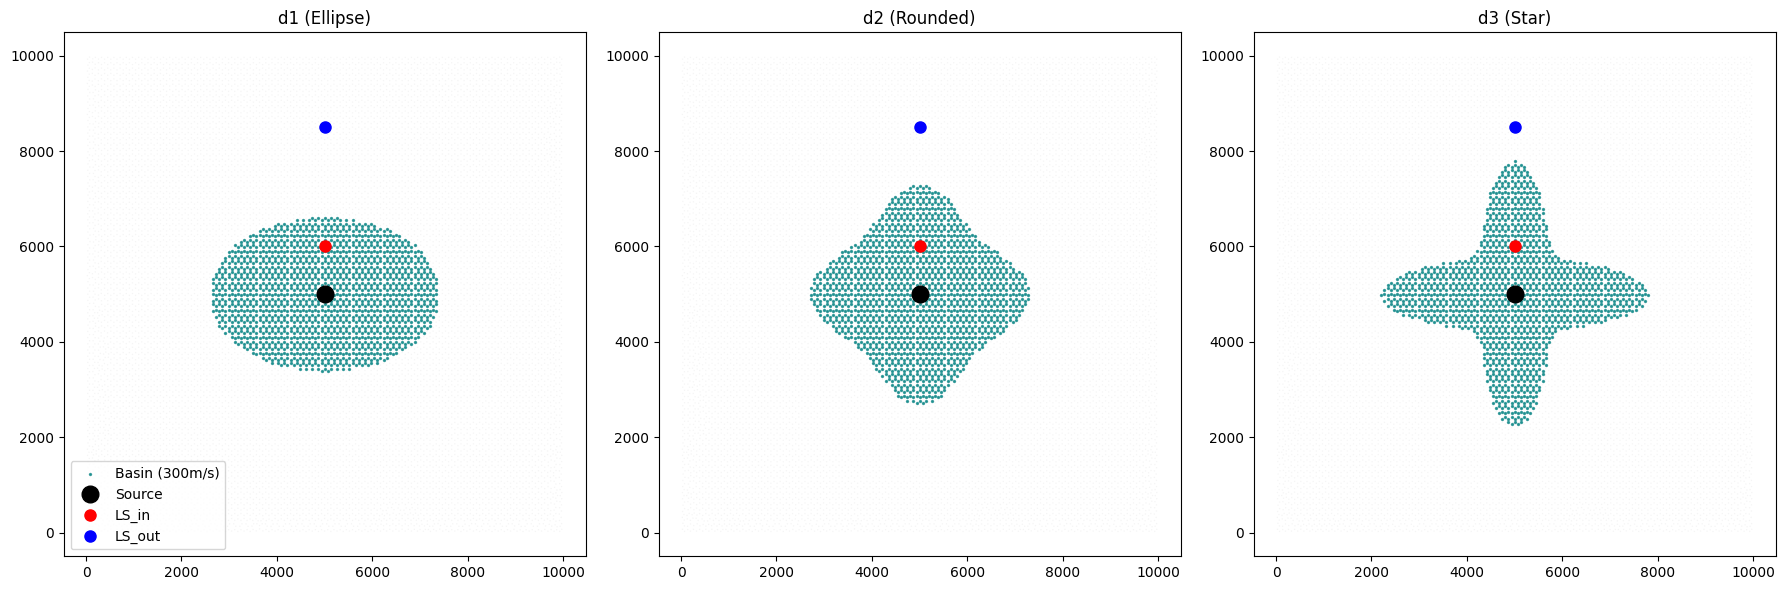

In [33]:
# Візуалізація областей
plt.figure(figsize=(18, 6))
for i, (name, data) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    centers = data['centers']
    mask = data['mask']

    plt.scatter(centers[~mask, 0], centers[~mask, 1], c='whitesmoke', s=1, edgecolor='none')
    plt.scatter(centers[mask, 0], centers[mask, 1], c='teal', s=2, alpha=0.7, label='Basin (300m/s)')

    plt.plot(source_pos[0], source_pos[1], 'ko', markersize=12, label='Source')
    plt.plot(rec_in_pos[0], rec_in_pos[1], 'ro', markersize=8, label='LS_in')
    plt.plot(rec_out_pos[0], rec_out_pos[1], 'bo', markersize=8, label='LS_out')

    plt.title(name)
    plt.axis('equal')
    if i == 0: plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

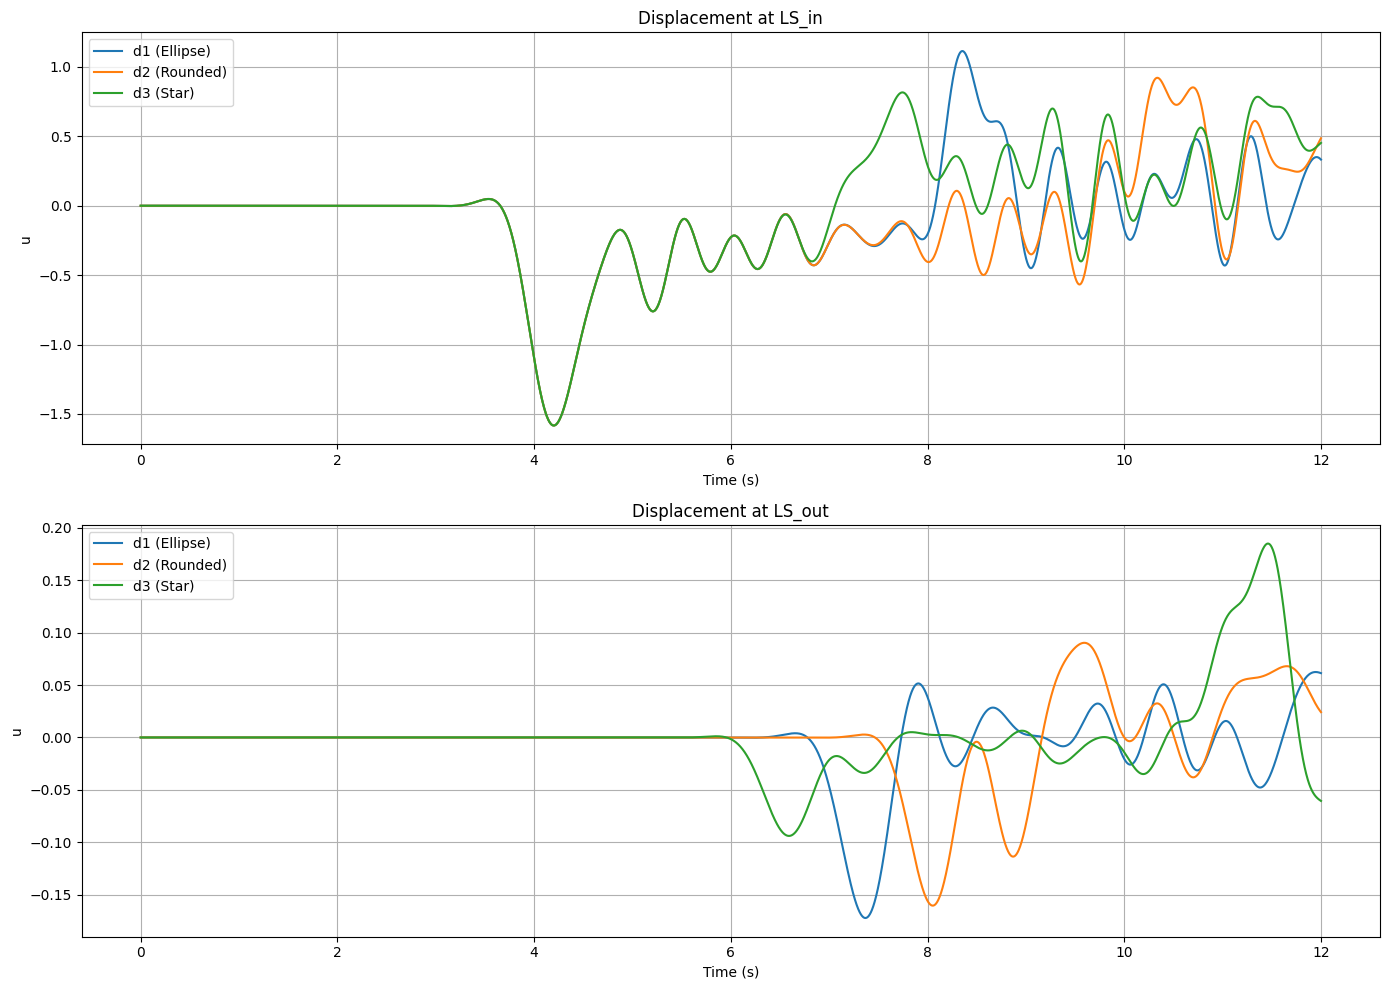

In [35]:
# Порівняння переміщення
plt.figure(figsize=(14, 10))

#LS_in
plt.subplot(2, 1, 1)
for name, data in results.items():
    plt.plot(t_arr, data['Lin'], label=name, linewidth=1.5)
plt.title("Displacement at LS_in")
plt.xlabel("Time (s)")
plt.ylabel("u")
plt.grid(True)
plt.legend()

#LS_out
plt.subplot(2, 1, 2)
for name, data in results.items():
    plt.plot(t_arr, data['Lout'], label=name, linewidth=1.5)
plt.title("Displacement at LS_out")
plt.xlabel("Time (s)")
plt.ylabel("u")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()